# Red Neuronal Recurrente LSTM 

### Este modelo de IA realizará el análisis técnico sobre la criptmoneda Bitcoin (BTC)

#### Importación de bibliotecas

In [140]:
import pandas as pd # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import seaborn as sns# type: ignore
from sklearn.preprocessing import MinMaxScaler# type: ignore
import numpy as np# type: ignore
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Input # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.metrics import MeanSquaredError # type: ignore

In [80]:
def categorize(change):
    if change >= 0.00:
        return 1
    else:
        return 0

#### Dataset

In [97]:
bp = pd.read_csv("./BitcoinHistoricalData.csv",index_col='Date',parse_dates=['Date']).iloc[::-1]

In [98]:
bp['Category'] = [categorize(i) for i in bp.Change]

Se verifica que los tipos de datos sean los correctos

In [83]:
bp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4598 entries, 2011-09-09 to 2024-04-10
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     4598 non-null   float64
 1   Open      4598 non-null   float64
 2   High      4598 non-null   float64
 3   Low       4598 non-null   float64
 4   Volume    4598 non-null   float64
 5   Change    4598 non-null   float64
 6   Category  4598 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 287.4 KB


In [84]:
bp.describe()

,Price,Open,High,Low,Volume,Change,Category
count,4598.000000,4598.000000,4598.000000,4598.000000,4.598000e+03,4598.000000,4598.000000
mean,12011.070966,11995.785211,12293.184732,11678.668900,1.343839e+07,0.003594,0.547629
std,16588.682283,16567.147432,16979.287829,16126.459103,1.614593e+08,0.069777,0.497780
min,2.000000,2.000000,2.300000,2.000000,2.600000e+02,-0.572100,0.000000
25%,338.975000,337.925000,352.875000,326.650000,3.810750e+04,-0.012400,0.000000
50%,4064.600000,4061.800000,4175.800000,3956.900000,7.722500e+04,0.000900,1.000000
75%,19057.375000,19053.925000,19355.575000,18478.350000,2.106225e+05,0.018800,1.000000
max,73066.300000,73066.700000,73740.900000,71338.400000,4.470000e+09,3.368400,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

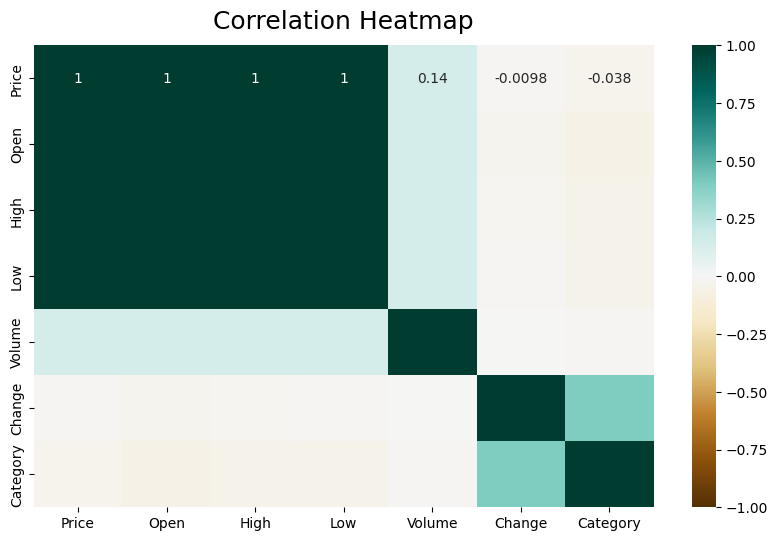

In [85]:
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(bp.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)

Verificación de valores nulos

In [86]:
bp.isnull().sum()

Price       0
Open        0
High        0
Low         0
Volume      0
Change      0
Category    0
dtype: int64

Dataset de Entrenamiento (2011 - 2019)

In [87]:
train_set = bp[:'2019'].iloc[:,[0]]
# train_set_target = to_categorical(bp[:'2019'].iloc[:,[6]], num_classes=3)

Dataset de Prueba (2022 - 2024)

In [88]:
test_set = bp['2022':'2023'].iloc[:,[0]]
# validation_set_target = to_categorical(bp['2022':'2023'].iloc[:,[6]], num_classes=3)

Visualizacion de Datasets

Text(0, 0.5, 'Precio')

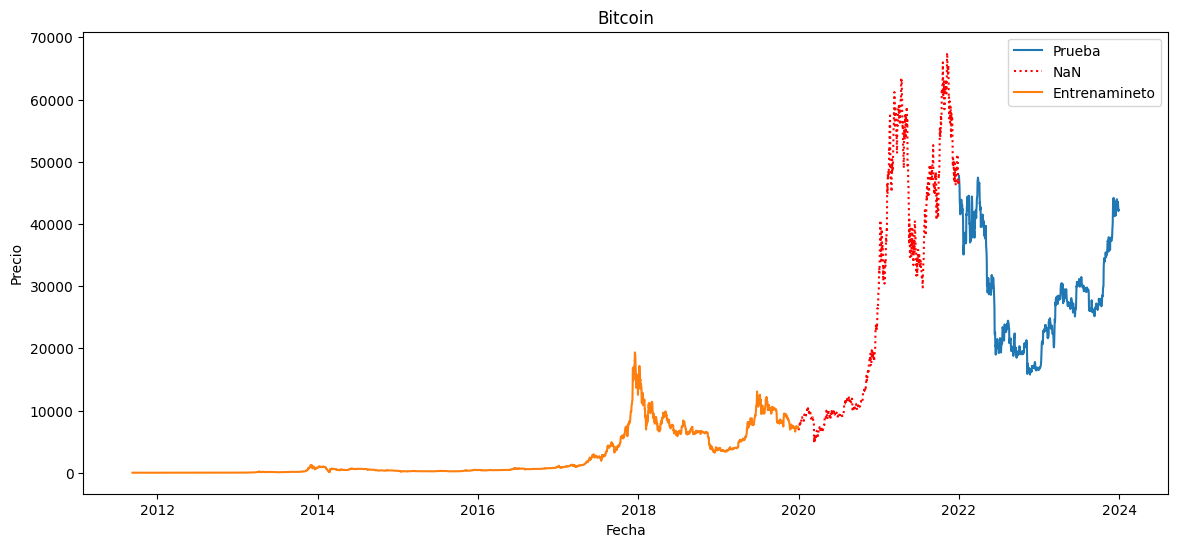

In [89]:
plt.figure(figsize=(14,6))
plt.title("Bitcoin")
sns.lineplot(x="Date", y="Price", data=test_set, label="Prueba")
sns.lineplot(x="Date", y="Price", data=bp['2020':'2021'].iloc[:,[0]], label="NaN",linestyle='dotted', color='red')
sns.lineplot(x="Date", y="Price", data=train_set, label="Entrenamineto")
plt.xlabel("Fecha")
plt.ylabel("Precio")

### Normalización de los datos

In [63]:
sc = MinMaxScaler(feature_range=(0,1))
train_set_scaled = sc.fit_transform(train_set)    

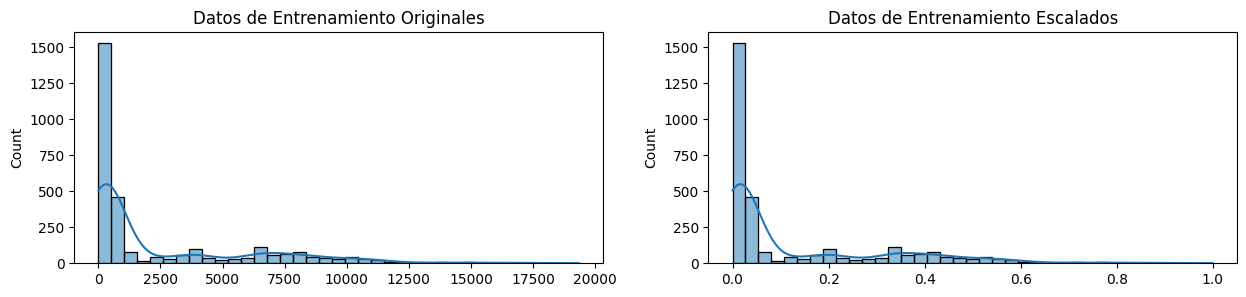

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
sns.histplot(train_set, ax=ax[0], kde=True, legend=False)
ax[0].set_title("Datos de Entrenamiento Originales")
sns.histplot(train_set_scaled, ax=ax[1], kde=True, legend=False)
ax[1].set_title("Datos de Entrenamiento Escalados")
plt.show()

### Ajuste de los sets de entrenamineto y validación

In [65]:
block_size = 60
X_train = []
Y_train = []    
m = len(train_set_scaled)

for i in range(block_size,m):
    # Para X_train toma los primeros 'block_size' valores del dataset y Y_train toma el siguiente valor 
    X_train.append(train_set_scaled[i-block_size:i,0])
    Y_train.append(train_set_scaled[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train) 

In [66]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
# X_train.shape

### Creación y entrenamiento de la Red LSTM

In [67]:
input_dim = (X_train.shape[1],X_train.shape[2])
output_dim = 1
na = 60

In [68]:
model = Sequential()
model.add(Input(shape=input_dim))
model.add(LSTM(units=na, return_sequences=True))
model.add(LSTM(units=na, return_sequences=False))
model.add(Dense(25))

model.add(Dense(units=output_dim))
model.compile(optimizer='adam', loss='mean_squared_error')
hist = model.fit(X_train,Y_train,epochs=20,batch_size=64)
model.summary()

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0093
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 6.1393e-04
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 6.4807e-04
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 4.3502e-04
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 4.9308e-04
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 4.2814e-04
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 3.7529e-04
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 3.7744e-04
Epoch 9/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 3.8566e-04
Epoch 10/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 3.2732e-04
Epoch 11/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 3.4469e-04
Epoch 12/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 3.8635e-04
Epoch 13/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 3.3479e-04
Epoch 14/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 2.2991e-04
Epoch 15/20
47/47 ━

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 60)         │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 60)             │        29,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,415 (532.88 KB)

 Trainable params: 45,471 (177.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 90,944 (355.25 KB)

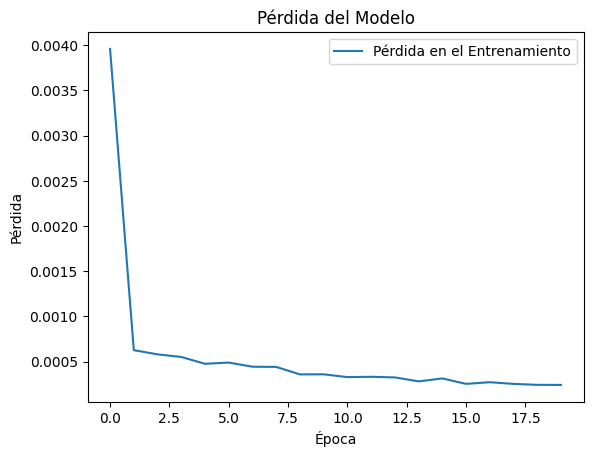

In [69]:
plt.plot(hist.history['loss'])
# plt.plot(hist.history['val_loss'])
plt.title("Pérdida del Modelo")
plt.ylabel("Pérdida")
plt.xlabel("Época")
plt.legend(["Pérdida en el Entrenamiento","Validation loss"])
plt.show()

### Prediccion

In [70]:
x_test = sc.transform(test_set)

In [106]:
X_test = []
for i in range(block_size,len(x_test)):
    X_test.append(x_test[i-block_size:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [77]:
prediccion = model.predict(X_test)
prediccion = sc.inverse_transform(prediccion)
graph = test_set[block_size:]
graph['Prediction']  = prediccion

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\jrmal\AppData\Local\Temp\ipykernel_13996\3736006923.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph['Prediction']  = prediccion


In [127]:
def change(pred):
    change = []
    for x in range(0,len(pred)):
        if x < len(pred)-1:
            if pred[x] < pred[x+1]:
                change.append(1)
            else:
                change.append(0)
        else:
            change.append(1)
    return change
graph['Change'] = change(prediccion)

Date
2011-11-08    1
2011-11-09    0
2011-11-10    0
2011-11-11    1
2011-11-12    1
             ..
2024-04-06    1
2024-04-07    1
2024-04-08    1
2024-04-09    0
2024-04-10    1
Name: Category, Length: 4538, dtype: int64

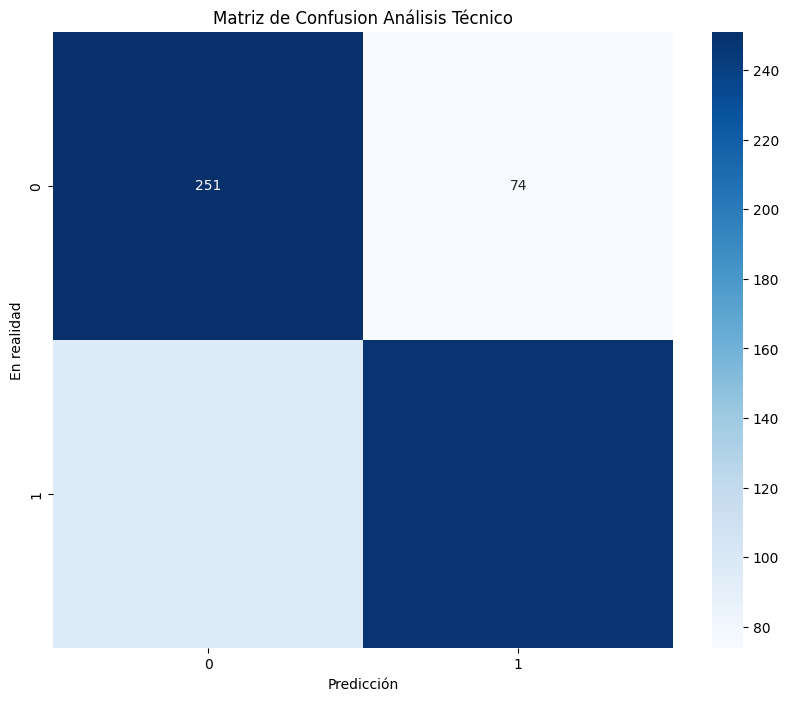

In [149]:

from sklearn.metrics import confusion_matrix
# Construct the confusion matrix
conf_matrix = confusion_matrix(graph["Change"], bp["Category"]["2022-03-02":"2023-12-31"])
# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["0", "1"], yticklabels=["0", "1"])
plt.xlabel('Predicción')
plt.ylabel('En realidad')
plt.title('Matriz de Confusion Análisis Técnico')
plt.show()

In [150]:
conf_matrix

array([[251,  74],
       [ 97, 248]], dtype=int64)

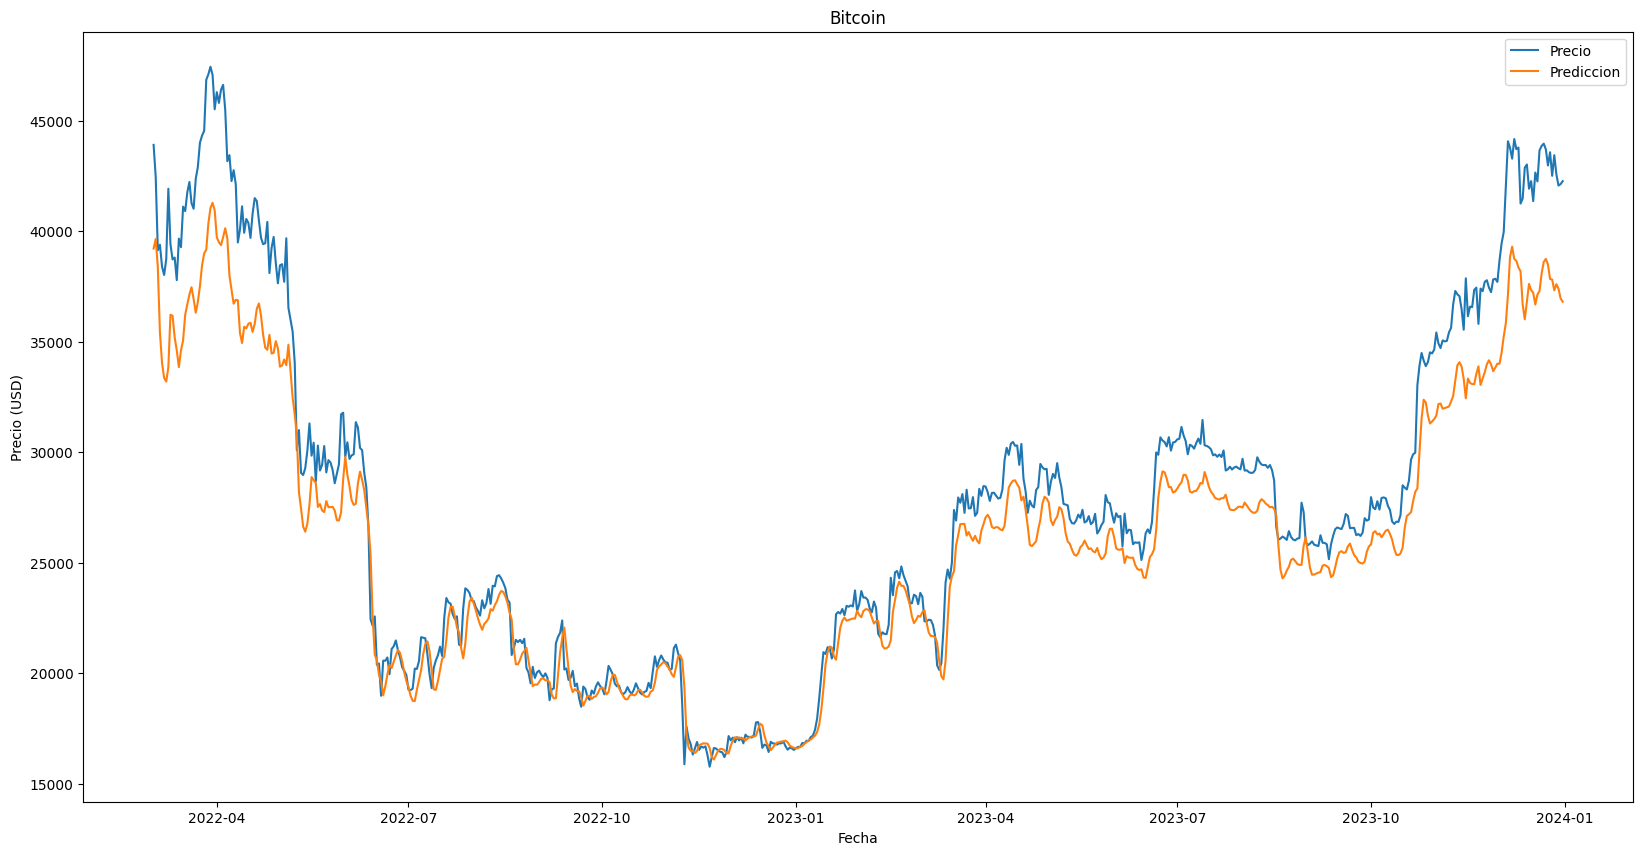

In [73]:
plt.figure(figsize=(20, 10))
sns.lineplot(x='Date', y='Price', data=graph, label='Precio')
sns.lineplot(x='Date', y='Prediction', data=graph, label='Prediccion')
plt.title('Bitcoin')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.show()